# CAM Methods Benchmark

**Goal:** to compare CAM methods using regular explaining metrics.  
**Author:** lucas.david@ic.unicamp.br

Use GPUs if you are running *Score-CAM* or *Quantitative Results* sections.

In [ ]:
#@title
 
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf

# base_dir = '/content/drive/MyDrive/'
base_dir = '/home/ldavid/Workspace'
# data_dir = '/root/tensorflow_datasets'
data_dir = '/home/ldavid/Workspace/datasets/'

class Config:
  seed = 218402

  class data:
    path = '/root/tensorflow_datasets/amazon-from-space'
    size = (256, 256)
    shape = (*size, 3)
    batch_size = 32
    shuffle_buffer_size = 8 * batch_size
    prefetch_buffer_size = tf.data.experimental.AUTOTUNE
    train_shuffle_seed = 120391
    shuffle = False

  class model:
    backbone = tf.keras.applications.ResNet101V2
    last_spatial_layer = 'post_relu'
    # backbone = tf.keras.applications.EfficientNetB6
    # last_spatial_layer = 'eb6'
    # backbone = tf.keras.applications.VGG16
    # last_spatial_layer = 'block5_pool'

    gap_layer_name = 'avg_pool'
    include_top = False
    classifier_activation = None

    custom = True
    fine_tune_layers = 0.6
    freeze_batch_norm = False

    weights = f'{base_dir}/logs/amazon-from-space/resnet101-sw-ce-fine-tune/weights.h5'
  
  class training:
    valid_size = 0.3

  class explaining:
    noise = tf.constant(.2)
    repetitions = tf.constant(8)

    score_cam_activations = 'all'

    λ_pos = tf.constant(1.)
    λ_neg = tf.constant(1.)
    λ_bg  = tf.constant(1.)

  report = f'{base_dir}/logs/amazon-from-space/resnet101-sw-ce-fine-tune/cam-score.txt'

In [ ]:
preprocess = tf.keras.applications.resnet_v2.preprocess_input
deprocess = lambda x: (x + 1) * 127.5

# preprocess = tf.keras.applications.res.preprocess_input
# deprocess = lambda x: x

# preprocess = tf.keras.applications.vgg16.preprocess_input
# deprocess = lambda x: x[..., ::-1] + [103.939, 116.779, 123.68]

to_image = lambda x: tf.cast(tf.clip_by_value(deprocess(x), 0, 255), tf.uint8)
masked = lambda x, maps: x * tf.image.resize(maps, Config.data.size)

## Setup

In [ ]:
! pip -qq install tensorflow_addons

In [ ]:
import os
import shutil
from time import time
from math import ceil

import numpy as np
import pandas as pd
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import callbacks

In [ ]:
for d in tf.config.list_physical_devices('GPU'):
  print(d)
  print(f'Setting device {d} to memory-growth mode.')
  try:
    tf.config.experimental.set_memory_growth(d, True)
  except Exception as e:
    print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Setting device PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') to memory-growth mode.
Physical devices cannot be modified after being initialized


In [ ]:
R = tf.random.Generator.from_seed(Config.seed, alg='philox')
C = np.asarray(sns.color_palette("Set1", 21))
CMAP = sns.color_palette("Set1", 21, as_cmap=True)

sns.set_style("whitegrid", {'axes.grid' : False})

In [ ]:
np.set_printoptions(linewidth=120)

In [ ]:
def normalize(x, reduce_min=True, reduce_max=True):
  if reduce_min: x -= tf.reduce_min(x, axis=(-3, -2), keepdims=True)
  if reduce_max: x = tf.math.divide_no_nan(x, tf.reduce_max(x, axis=(-3, -2), keepdims=True))

  return x

def visualize(
    image,
    title=None,
    rows=2,
    cols=None,
    i0=0,
    figsize=(9, 4),
    cmap=None,
    full=True
):
  if image is not None:
    if isinstance(image, (list, tuple)) or len(image.shape) > 3:  # many images
      if full: plt.figure(figsize=figsize)
      cols = cols or ceil(len(image) / rows)
      for ix in range(len(image)):
        plt.subplot(rows, cols, i0+ix+1)
        visualize(image[ix],
                 cmap=cmap,
                 title=title[ix] if title is not None and len(title) > ix else None)
      if full: plt.tight_layout()
      return

    if isinstance(image, tf.Tensor): image = image.numpy()
    if image.shape[-1] == 1: image = image[..., 0]
    plt.imshow(image, cmap=cmap)
  
  if title is not None: plt.title(title)
  plt.axis('off')

In [ ]:
def observe_labels(probs, labels, ix):
  p = probs[ix]
  l = labels[ix]
  s = tf.argsort(p, direction='DESCENDING')

  d = pd.DataFrame({
    'idx': s,
    'label': tf.gather(CLASSES, s).numpy().astype(str),
    'predicted': tf.gather(p, s).numpy().round(2),
    'ground-truth': tf.gather(l, s).numpy()
  })

  return d[(d['ground-truth']==1) | (d['predicted'] > 0.05)]


def plot_heatmap(i, m):
    plt.imshow(i)
    plt.imshow(m, cmap='jet', alpha=0.5)
    plt.axis('off')

## Related Work

### Summary

In [ ]:
#@title

d = [
  ['1512.04150', 'CAM',      'GoogleNet', 'ILSVRC-15 val',   56.4,  43.00, None, None, None, None],
  ['1512.04150', 'CAM',      'VGG-16',    'ILSVRC-15 val',   57.2,  45.14, None, None, None, None],
  ['1512.04150', 'Backprop', 'GoogleNet', 'ILSVRC-15 val',   61.31, 50.55, None, None, None, None],
  ['1512.04150', 'Backprop', 'GoogleNet', 'ILSVRC-15 test',  None,  37.10, None, None, None, None],
  
  ['1610.02391', 'CAM',      'VGG-16',    'ILSVRC-15 val',   57.2,  45.14, None, None, None, None, None],
  ['1610.02391', 'Grad-CAM', 'VGG-16',    'ILSVRC-15 val',   56.51, 46.41, None, None, None, None, None],
  ['1610.02391', 'CAM',      'GoogleNet', 'ILSVRC-15 val',   60.09, 49.34, None, None, None, None, None],
  ['1610.02391', 'Grad-CAM', 'GoogleNet', 'ILSVRC-15 val',   60.09, 49.34, None, None, None, None, None],

  ['1710.11063', 'Grad-CAM',   'VGG-16',    'ILSVRC-2012 val', None, None, 46.56, 13.42, 29.28, None, None],
  ['1710.11063', 'Grad-CAM++', 'VGG-16',    'ILSVRC-2012 val', None, None, 36.84, 17.05, 70.72, None, None],
  ['1710.11063', 'Grad-CAM',   'AlexNet',   'ILSVRC-2012 val', None, None, 82.86, 3.16,  13.44, None, None],
  ['1710.11063', 'Grad-CAM++', 'AlexNet',   'ILSVRC-2012 val', None, None, 62.75, 8.24,  86.56, None, None],
  ['1710.11063', 'Grad-CAM',   'VGG-16',    'Pascal 2007 val', None, None, 28.54, 21.43, 39.44, None, None],
  ['1710.11063', 'Grad-CAM++', 'VGG-16',    'Pascal 2007 val', None, None, 19.53, 18.96, 61.47, None, None],
  ['1710.11063', 'Grad-CAM',   'AlexNet',   'Pascal 2007 val', None, None, 45.82, 14.38, 27.21, None, None],
  ['1710.11063', 'Grad-CAM++', 'AlexNet',   'Pascal 2007 val', None, None, 29.16, 19.76, 72.79, None, None],
  ['1710.11063', 'Grad-CAM',   'ResNet-50', 'ILSVRC-2012 val', None, None, 30.36, 22.11, 39.49, None, None],
  ['1710.11063', 'Grad-CAM++', 'ResNet-50', 'ILSVRC-2012 val', None, None, 28.90, 22.16, 60.51, None, None],
  ['1710.11063', 'Grad-CAM',   'ResNet-50', 'Pascal 2007 val', None, None, 20.86, 21.99, 41.39, None, None],
  ['1710.11063', 'Grad-CAM++', 'ResNet-50', 'Pascal 2007 val', None, None, 16.19, 19.52, 58.61, None, None],

  ['1710.11063', 'Grad-CAM',   'VGG-16',  'Pascal 2012 val', None, None, None, None, None, 0.33, None],
  ['1710.11063', 'Grad-CAM++', 'VGG-16',  'Pascal 2012 val', None, None, None, None, None, 0.34, None],

  ['1910.01279', 'Backprop Vanilla',   'VGG-16', 'ILSVRC-2012 val', None, None, None, None, None, None, 41.3],
  ['1910.01279', 'Backprop Smooth',     'VGG-16', 'ILSVRC-2012 val', None, None, None, None, None, None, 42.4],
  ['1910.01279', 'Backprop Integraded', 'VGG-16', 'ILSVRC-2012 val', None, None, None, None, None, None, 44.7],

  ['1910.01279', 'Grad-CAM',   'VGG-16', 'ILSVRC-2012 val', None, None, 47.80, 19.60, None, None, 48.1],
  ['1910.01279', 'Grad-CAM++', 'VGG-16', 'ILSVRC-2012 val', None, None, 45.50, 18.90, None, None, 49.3],
  ['1910.01279', 'Score-CAM',  'VGG-16', 'ILSVRC-2012 val', None, None, 31.50, 30.60, None, None, 63.7],
]

d = pd.DataFrame(
  d,
  columns=[
    'Source', 'Method', 'Arch', 'Dataset',
    'Loc_Error_T-1', 'Loc_Error_T-5',
    'Avg_Drop', 'Incr_in_confidence', 'Win_%', 'mLoc_I^c(s=0)',
    'E-Pointing_Game'
  ]
)

In [ ]:
#@title

(d.groupby(['Dataset', 'Method'], as_index=False)
  .mean()
  .replace(np.nan, '', regex=True))

,Dataset,Method,Loc_Error_T-1,Loc_Error_T-5,Avg_Drop,Incr_in_confidence,Win_%,mLoc_I^c(s=0),E-Pointing_Game
0,ILSVRC-15 test,Backprop,,37.1,,,,,
1,ILSVRC-15 val,Backprop,61.31,50.55,,,,,
2,ILSVRC-15 val,CAM,57.7225,45.655,,,,,
3,ILSVRC-15 val,Grad-CAM,58.3,47.875,,,,,
4,ILSVRC-2012 val,Backprop Integraded,,,,,,,44.7
5,ILSVRC-2012 val,Backprop Smooth,,,,,,,42.4
6,ILSVRC-2012 val,Backprop Vanilla,,,,,,,41.3
7,ILSVRC-2012 val,Grad-CAM,,,51.895,14.5725,27.403333,,48.1
8,ILSVRC-2012 val,Grad-CAM++,,,43.4975,16.5875,72.596667,,49.3
9,ILSVRC-2012 val,Score-CAM,,,31.5,30.6,,,63.7


In [ ]:
#@title Full Report

d.replace(np.nan, '', regex=True)

,Source,Method,Arch,Dataset,Loc_Error_T-1,Loc_Error_T-5,Avg_Drop,Incr_in_confidence,Win_%,mLoc_I^c(s=0),E-Pointing_Game
0,1512.04150,CAM,GoogleNet,ILSVRC-15 val,56.4,43.0,,,,,
1,1512.04150,CAM,VGG-16,ILSVRC-15 val,57.2,45.14,,,,,
2,1512.04150,Backprop,GoogleNet,ILSVRC-15 val,61.31,50.55,,,,,
3,1512.04150,Backprop,GoogleNet,ILSVRC-15 test,,37.1,,,,,
4,1610.02391,CAM,VGG-16,ILSVRC-15 val,57.2,45.14,,,,,
5,1610.02391,Grad-CAM,VGG-16,ILSVRC-15 val,56.51,46.41,,,,,
6,1610.02391,CAM,GoogleNet,ILSVRC-15 val,60.09,49.34,,,,,
7,1610.02391,Grad-CAM,GoogleNet,ILSVRC-15 val,60.09,49.34,,,,,
8,1710.11063,Grad-CAM,VGG-16,ILSVRC-2012 val,,,46.56,13.42,29.28,,
9,1710.11063,Grad-CAM++,VGG-16,ILSVRC-2012 val,,,36.84,17.05,70.72,,


**Localization Error**

As defined in http://image-net.org/challenges/LSVRC/2015/index#maincomp:

Let $d(c_i,C_k)=0$ if $c_i=C_k$ and 1 otherwise. Let $f(b_i,B_k)=0$ if $b_i$ and $B_k$ have more than 50% overlap, and 1 otherwise. The error of the algorithm on an individual image will be computed using:

$$e=\frac{1}{n} \cdot \sum_k min_{i} min_{m}  max \{d(c_i,C_k), f(b_i,B_{km}) \}$$

**Pixel Perturbation** (Full-Gradient)

First form: remove $k$ most salient pixels from the image and measure impact on output confidence (high impact expected for good saliency methods, similar to Avg. Drop %). This might add artifacts (edges).

Second form: remove $k$ least salient pixels from the image and measure output confidence (low impact expected for good saliency methods).

**Average Drop %** (Grad-CAM++, Score-CAM)

The avg. percentual drop in the confidence of a model for a particular image $x_i$ and class $c$, when only the highlighted region is provided ($M_i\circ x_i$):

$$∑_i^N \frac{max(0, Y_i^c − O_i^c)}{Y_i^c} 100$$

* $Y_i^c = f(x_i)^c$
* $O_i^c = f(M_i\circ x_i)^c$

**Increase in confidence %** (Grad-CAM++, Score-CAM)

Measures scenarios where removing background noise must improve classification confidence.

$$∑^N_i \frac{Y^c_i < O^c_i}{N}100$$


### CAM

$M(f, x)^u_{ij} = \text{relu}(\sum_k w^u_k A_{ij}^k)$

In [ ]:
@tf.function
def sigmoid_cam(x, y):
  print(f'CAM tracing x:{x.shape} y:{y.shape}')

  l, a = nn_s(x, training=False)
  y = tf.einsum('bhwk,ku->buhw', a, sW)

  return l, y[..., tf.newaxis]

### Grad-CAM

$M(f, x)^u_{ij} = \text{relu}(\sum_k \sum_{lm}\frac{\partial S_u}{\partial A_{lm}^k} A_{ij}^k)$

In [ ]:
@tf.function
def sigmoid_gradcam(x, y):
  print(f'Grad-CAM tracing x:{x.shape} y:{y.shape}')

  with tf.GradientTape(watch_accessed_variables=False) as t:
    t.watch(x)
    l, a = nn_s(x, training=False)

  dlda = t.batch_jacobian(l, a)

  weights = tf.reduce_sum(dlda, axis=(-3, -2))  # bc(hw)k -> bck
  maps = tf.einsum('bhwc,buc->buhw', a, weights)

  return l, maps[..., tf.newaxis]


Note that for fully-convolutional network, with a single densely-connected softmax classifier at its end:

$S_u = \sum_k w^k_u [\frac{1}{hw}\sum_{lm}^{hw} A^k_{lm}]$

Then:

\begin{align}
\frac{\partial S_u}{\partial A_{lm}^k} &= \frac{\partial}{\partial A_{lm}^k} \sum_k w^k_u [\frac{1}{hw}\sum_{lm}^{hw} A^k_{lm}] \\
  &= w^k_u [\frac{1}{hw}\frac{\partial A^k_{lm}}{\partial A^k_{lm}}] \\
  &= \frac{w^k_u}{hw}
\end{align}

All constants (including $\frac{1}{hw}$) are erased when we apply normalization.
Therefore, in these conditions, this this method is equivalent to `CAM`.

### Grad-CAM++

$M(f, x)^u_{ij} = \sum_k \sum_{lm} \alpha_{lm}^{ku} \text{relu}(\frac{\partial S_u}{\partial A_{lm}^k}) A_{ij}^k$

Where

$\alpha_{lm}^{ku} = \frac{(\frac{\partial S_u}{\partial A_{lm}^k})^2}{2(\frac{\partial S_u}{\partial A_{lm}^k})^2 + \sum_{ab} A_{ab}^k(\frac{\partial S_u}{\partial A_{lm}^k})^3}$

In [ ]:
@tf.function
def sigmoid_gradcampp(x, y):
  print(f'Grad-CAM++ tracing x:{x.shape} y:{y.shape}')

  with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(x)
    s, a = nn_s(x, training=False)

  dsda = tape.batch_jacobian(s, a)

  dyda = tf.einsum('bu,buhwk->buhwk', tf.exp(s), dsda)
  d2 = dsda**2
  d3 = dsda**3
  aab = tf.reduce_sum(a, axis=(1, 2))              # (BK)
  akc = tf.math.divide_no_nan(
    d2,
    2.*d2 + tf.einsum('bk,buhwk->buhwk', aab, d3))  # (2*(BUHWK) + (BK)*BUHWK)

  weights = tf.einsum('buhwk,buhwk->buk', akc, tf.nn.relu(dyda))  # w: buk
  maps = tf.einsum('buk,bhwk->buhw', weights, a)                  # a:bhwk, m: buhw

  return s, maps[..., tf.newaxis]

### Score CAM

$M(f, x)^u_{ij} = \text{relu}(∑_k \text{softmax}(C(A_l^k)_u) A_l^k)$

Where

$
C(A_l^k)_u = f(X_b \circ \psi(\text{up}(A_l^k)))_u - f(X_b)_u
$


This algorithm has gone through updated. I followed the most recent implementation in [haofanwang/Score-CAM](https://github.com/haofanwang/Score-CAM/blob/master/cam/scorecam.py#L47).

In [ ]:
def sigmoid_scorecam(x, y):
  acts_used = Config.explaining.score_cam_activations

  l, a = nn_s(x, training=False)

  if acts_used == 'all' or acts_used is None:
    acts_used = a.shape[-1]

  # Sorting kernels from highest to lowest variance.
  std = tf.math.reduce_std(a, axis=(1, 2))
  a_high_std = tf.argsort(std, axis=-1, direction='DESCENDING')[:, :acts_used]
  a = tf.gather(a, a_high_std, axis=3, batch_dims=1)

  s = tf.Variable(tf.zeros((x.shape[0], y.shape[1], *Config.data.size)), name='sc_maps')

  for ix in range(acts_used):
    a_ix = a[..., ix:ix+1]

    if tf.reduce_min(a_ix) == tf.reduce_max(a_ix):
      break

    s.assign_add(_scorecam_feed(x, a_ix))
  
  return l, s[..., tf.newaxis]

@tf.function
def _scorecam_feed(x, a_ix):
  print('Score-CAM feed tracing')
  a_ix = tf.image.resize(a_ix, Config.data.size)

  b = normalize(a_ix)
  fm = nn(x * b, training=False)
  fm = tf.nn.sigmoid(fm)
  fm = tf.einsum('bc,bhw->bchw', fm, a_ix[..., 0])

  return fm

Vectorized implementation:

The number of activating kernels used was defined in `Config.explaining.score_cam_activations`.  
For each batch of 16 samples (`100 MB = 16 × 512×512×3 × 8÷1000÷1000`):

1. 16 samples are feed-forwarded, generating the logits `(16, 20)` and activations `(16, 16, 16, score_cam_activations)`
2. The masked input `(16 × score_cam_activations, 512, 512, 3)` is created (`score_cam_activations × 100 MB`).
3. The masked input is feed-forwarded (batching used to prevent the GPU from blowing up).


```python
def sigmoid_scorecam(x, y):
  acts_used = Config.explaining.score_cam_activations

  l, a = nn_s(x, training=False)

  std = tf.math.reduce_std(a, axis=(1, 2))
  a_high_std = tf.argsort(std, axis=-1, direction='DESCENDING')[:, :acts_used]
  a = tf.gather(a, a_high_std, axis=-1, batch_dims=-1)

  a = tf.image.resize(a, Config.data.size)
  b = normalize(a)

  b = tf.einsum('bhwc,bhwk->bkhwc', x, b)      # outer product over 2 ranks
  b = tf.reshape(b, (-1, *Config.data.shape))  # batchify (B*A, H, W, C)

  fm = nn.predict(b, batch_size=Config.data.batch_size)
  fm = tf.nn.sigmoid(fm)
  fm = tf.reshape(fm, (x.shape[0], acts_used, fm.shape[1]))  # unbatchify

  s = tf.einsum('bhwk,bkc->bchw', a, fm)
  s = tf.nn.relu(s)
  s = s[..., tf.newaxis]

  return l, s
```

## Dataset

### Augmentation Policy

In [ ]:
def default_policy_fn(image):
  # image = tf.image.resize_with_crop_or_pad(image, *Config.data.size)
  # mask = tf.image.resize_with_crop_or_pad(mask, *Config.data.size)

  return image

### Preparing and Performance Settings

In [ ]:
data_path = Config.data.path

In [ ]:
%%bash

if [ ! -d /root/tensorflow_datasets/amazon-from-space/ ]; then
  mkdir -p /root/tensorflow_datasets/amazon-from-space/

  # gdown --id 12wCmah0FFPIjI78YJ2g_YWFy97gaA5S9 --output /root/tensorflow_datasets/amazon-from-space/train-jpg.tfrecords

  cp /content/drive/MyDrive/datasets/amazon-from-space/train-jpg.tfrecords \
     /root/tensorflow_datasets/amazon-from-space/
else
  echo "Dir $data_path found. Skipping."
fi

In [ ]:
class AmazonFromSpace:
    num_train_samples = 40479
    num_test_samples  = 61191

    classes_ = np.asarray(
        ['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down',
         'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze',
         'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water'])

    @classmethod
    def int2str(cls, indices):
        return cls.classes_[indices]
    
    @staticmethod
    def _bytes_feature(value):
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.tobytes()]))

    @staticmethod
    def _int64_feature(value):
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
    
    @staticmethod
    def decode_fn(record_bytes):
        r = tf.io.parse_single_example(record_bytes, {
          'filename': tf.io.FixedLenFeature([], tf.string),
          'image': tf.io.FixedLenFeature([], tf.string),
          'height': tf.io.FixedLenFeature([], tf.int64, default_value=[256]),
          'width': tf.io.FixedLenFeature([], tf.int64, default_value=[256]),
          'channels': tf.io.FixedLenFeature([], tf.int64, default_value=[3]),
          'label': tf.io.VarLenFeature(tf.int64),
        })
        
        r['image'] = tf.reshape(tf.io.decode_raw(r['image'], tf.uint8),
                                (r['height'], r['width'], r['channels']))
        r['label'] = tf.sparse.to_dense(r['label'])

        return r
    
    @classmethod
    def load(cls, tfrecords_path):
        return tf.data.TFRecordDataset(tfrecords_path).map(cls.decode_fn, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
CLASSES = AmazonFromSpace.classes_
int2str = AmazonFromSpace.int2str
num_samples = AmazonFromSpace.num_train_samples
num_train_samples = int((1-Config.training.valid_size)*num_samples)
num_valid_samples = int(Config.training.valid_size*num_samples)

In [ ]:
from functools import partial


@tf.function
def load_fn(d, augment=False):
  image = d['image']
  labels = d['label']

  image = tf.cast(image, tf.float32)
  image = tf.ensure_shape(image, Config.data.shape)

  # image, _ = adjust_resolution(image)
  image = (augment_policy_fn(image)
           if augment
           else default_policy_fn(image))
  
  image = preprocess(image)

  return image, labels_to_one_hot(labels)


def adjust_resolution(image):
  es = tf.constant(Config.data.size, tf.float32)
  xs = tf.cast(tf.shape(image)[:2], tf.float32)

  ratio = tf.reduce_min(es / xs)
  xsn = tf.cast(tf.math.ceil(ratio * xs), tf.int32)

  image = tf.image.resize(image, xsn, preserve_aspect_ratio=True, method='nearest')

  return image, ratio


def labels_to_one_hot(labels):
  return tf.reduce_max(
      tf.one_hot(labels, depth=CLASSES.shape[0]),
    axis=0)


def prepare(ds, batch_size, cache=False, shuffle=False, augment=False):
  if cache: ds = ds.cache()
  if shuffle: ds = ds.shuffle(Config.data.shuffle_buffer_size, reshuffle_each_iteration=True, seed=Config.data.train_shuffle_seed)

  return (ds.map(partial(load_fn, augment=augment), num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size, drop_remainder=True)
            .prefetch(Config.data.prefetch_buffer_size))

In [ ]:
train_dataset = AmazonFromSpace.load(f'{data_dir}/amazon-from-space/train-jpg.tfrecords')
valid_dataset = train_dataset.take(num_valid_samples)
train_dataset = train_dataset.skip(num_valid_samples)

# train = prepare(train_dataset, Config.data.batch_size)
valid = prepare(valid_dataset, Config.data.batch_size)

### Examples in The Dataset

In [ ]:
#@title

for stage, batches, samples in zip(('validation',),
                                   (valid,),
                                   (num_valid_samples,)):
  print(stage)
  print(f'  {batches}')
  print(f'  samples: {samples}')
  print(f'  steps  : {samples // Config.data.batch_size}')
  print()

validation
  <PrefetchDataset shapes: ((32, 256, 256, 3), (32, 17)), types: (tf.float32, tf.float32)>
  samples: 12143
  steps  : 379



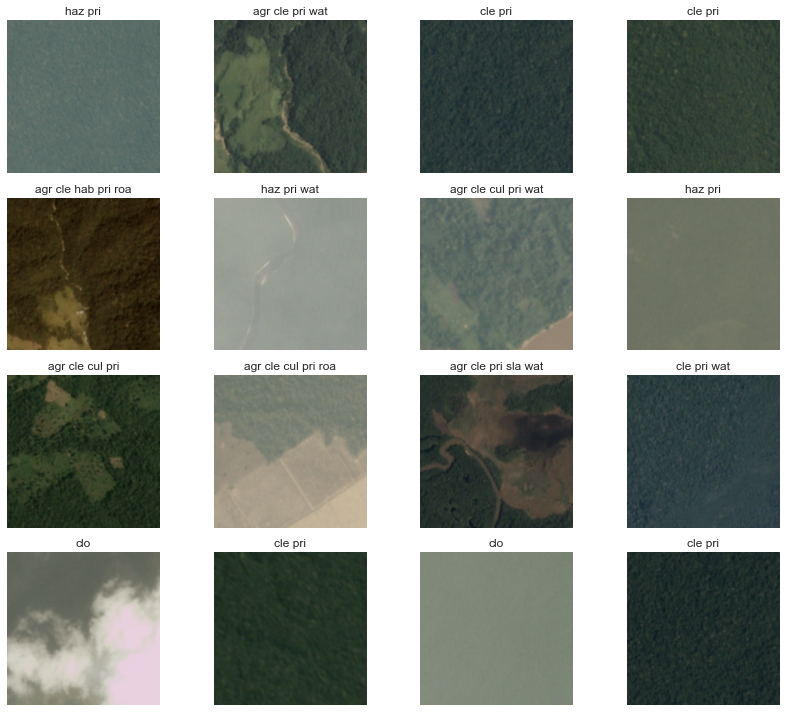

In [ ]:
#@title

for images, labels in valid.take(1):
  gt = [' '.join((e[:3] for e in CLASSES[l].astype(str))) for l in labels.numpy().astype(bool)]
  visualize(to_image(images[:16]), gt, rows=4, figsize=(12, 10));

## Network

In [ ]:
print(f'Loading {Config.model.backbone.__name__}')

backbone = Config.model.backbone(
  input_shape=Config.data.shape,
  include_top=Config.model.include_top,
  classifier_activation=Config.model.classifier_activation,
)

Loading ResNet101V2


In [ ]:
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GlobalAveragePooling2D

class DenseKur(Dense):
  """Dense with Softmax Weights.
  """
  def call(self, inputs):
    kernel = self.kernel
    ag = kernel  # tf.abs(kernel)
    ag = ag - tf.reduce_max(ag, axis=-1, keepdims=True)
    ag = tf.nn.softmax(ag)

    outputs = inputs @ (ag*kernel)

    if self.use_bias:
      outputs = tf.nn.bias_add(outputs, self.bias)

    if self.activation is not None:
      outputs = self.activation(outputs)

    return outputs

In [ ]:
def build_specific_classifier(
    backbone,
    classes,
    dropout_rate=0.5,
    name=None,
    gpl='avg_pool',
):
  x = tf.keras.Input(Config.data.shape, name='images')
  y = backbone(x)
  y = GlobalAveragePooling2D(name='avg_pool')(y)
  # y = Dense(classes, name='predictions')(y)
  y = DenseKur(classes, name='predictions')(y)

  return tf.keras.Model(x, y, name=name)

backbone.trainable = False
nn = build_specific_classifier(backbone, len(CLASSES), name='resnet101_afs')

In [ ]:
if Config.model.fine_tune_layers:
  print(f'Unfreezing {Config.model.fine_tune_layers:.0%} layers.')

  backbone.trainable = True
  frozen_layer_ix = int((1-Config.model.fine_tune_layers) * len(backbone.layers))

  for ix, l in enumerate(backbone.layers):
    l.trainable = (ix > frozen_layer_ix and
                  (not isinstance(l, tf.keras.layers.BatchNormalization) or
                    not Config.model.freeze_batch_norm))
  
print(f'Loading weights from {Config.model.weights}')
nn.load_weights(Config.model.weights)

Unfreezing 60% layers.
Loading weights from /home/ldavid/Workspace/logs/amazon-from-space/resnet101-sw-ce-fine-tune/weights.h5


In [ ]:
backbone.trainable = False

In [ ]:
nn_s = tf.keras.Model(
  inputs=nn.inputs,
  outputs=[nn.output, nn.get_layer(Config.model.gap_layer_name).input],
  name='nn_spatial')

In [ ]:
sW, sb = nn_s.get_layer('predictions').weights
sW = sW * tf.nn.softmax(sW - tf.reduce_max(sW, axis=-1, keepdims=True))

## Saliency Methods

In [ ]:
DT = 0.5

λ_pos = Config.explaining.λ_pos
λ_neg = Config.explaining.λ_neg
λ_bg = Config.explaining.λ_bg

### Min-Max CAM (ours, test ongoing)

$M(f, x)^u_{ij} = \sum_k [w^u_k - \frac{1}{|N_x|} \sum_{n\in N_x} w_k^n] A_{i,j}^k$

Where

$N_x = C_x\setminus \{u\}$

In [ ]:
@tf.function
def min_max_sigmoid_cam(x, y):
  print(f'Min-Max CAM (tracing x:{x.shape} p:{y.shape})')

  l, a = nn_s(x, training=False)

  c = len(CLASSES)
  s_n = tf.reduce_sum(sW, axis=-1, keepdims=True)
  s_n = s_n - sW

  w = λ_pos*sW - λ_neg*s_n/(c-1)

  maps = tf.einsum('bhwk,ku->buhw', a, w)
  return l, maps[..., tf.newaxis]

In [ ]:
@tf.function
def contextual_min_max_sigmoid_cam(x, y):
  print(f'Contextual Min-Max CAM (tracing x:{x.shape} p:{y.shape})')

  l, a = nn_s(x, training=False)
  p = tf.nn.sigmoid(l)

  d = tf.cast(p > DT, tf.float32)
  c = tf.reduce_sum(d, axis=-1)
  c = tf.reshape(c, (-1, 1, 1))     # detections (b, 1)

  w = d[:, tf.newaxis, :] * sW[tf.newaxis, ...]  # expand kernels in d and batches in sW
  w_n = tf.reduce_sum(w, axis=-1, keepdims=True)
  w_n = w_n - w

  w = λ_pos*sW - λ_neg*w_n / tf.maximum(c-1, 1)

  maps = tf.einsum('bhwk,bku->buhw', a, w)
  return l, maps[..., tf.newaxis]

#### Contextual ReLU MinMax

$M(f, x)^u_{ij} = \sum_k [w^{u+}_k - \frac{1}{|N_x|} \sum_{n\in N_x} w^{n+}_k +\frac{1}{|C_i|}\sum_{n\in C_i} w^{n-}_k] A_{i,j}^k$

Where

$N_x = C_x\setminus \{u\}$

In [ ]:
@tf.function
def contextual_relu_min_max_sigmoid_cam(x, y):
  print(f'Contextual ReLU Min-Max CAM (tracing x:{x.shape} p:{y.shape})')

  l, a = nn_s(x, training=False)
  p = tf.nn.sigmoid(l)

  d = tf.cast(p > DT, tf.float32)
  c = tf.reshape(tf.reduce_sum(d, axis=-1), (-1, 1, 1))  # select only detected

  w = d[:, tf.newaxis, :] * sW[tf.newaxis, ...]  # expand kernels in d and batches in sW
  wa = tf.reduce_sum(w, axis=-1, keepdims=True)
  wn = wa - w

  w = (  λ_pos * tf.nn.relu(sW)
       - λ_neg * tf.nn.relu(wn) / tf.maximum(c-1, 1)
       + λ_bg  * tf.minimum(0., wa) / tf.maximum(c, 1))

  maps = tf.einsum('bhwk,bku->buhw', a, w)
  return l, maps[..., tf.newaxis]

In [ ]:
@tf.function
def contextual_relu_min_max_sigmoid_cam_2(x, y):
  l, a = nn_s(x, training=False)
  p = tf.nn.sigmoid(l)

  aw = tf.einsum('bhwk,ku->buhw', a, sW)

  d = p > DT
  c = tf.reduce_sum(tf.cast(d, tf.float32), axis=-1)
  c = tf.reshape(c, (-1, 1, 1, 1))

  e = tf.repeat(d[:, tf.newaxis, ...], d.shape[1], axis=1)
  e = tf.linalg.set_diag(e, tf.fill(e.shape[:-1], False))

  z = tf.fill(aw.shape, -np.inf)

  an = tf.where(e[..., tf.newaxis, tf.newaxis], aw[:, tf.newaxis, ...], z[:, tf.newaxis, ...])
  ab = tf.where(d[..., tf.newaxis, tf.newaxis], aw, z)

  an = tf.reduce_max(an, axis=2)
  ab = tf.reduce_max(ab, axis=2, keepdims=True)

  maps = (
      tf.maximum(0., aw)
    - tf.maximum(0., an)
    + tf.minimum(0., ab)
  )

  return l, maps[..., tf.newaxis]

### Min-Max Grad-CAM (ours, test ongoing)

$M(f, x)^u_{ij} = \text{relu}(\sum_k \sum_{l,m}\frac{\partial J_u}{\partial A_{l,m}^k} A_{i,j}^k)$

Where

$J_u = S_u - \frac{1}{|N|} \sum_{n\in N_x} S_n$  
$N_x = C_x\setminus \{u\}$


In [ ]:
def min_max_activation_gain(y, s):
  c = len(CLASSES)
                                                  # shape(s)   == (b, c)
  s_n = tf.reduce_sum(s, axis=-1, keepdims=True)  # shape(s_n) == (b)
  s_n = s_n-s                                     # shape(s_n) == (b, c)

  return λ_pos*s - λ_neg*s_n / (c-1)

@tf.function
def min_max_sigmoid_gradcam(x, y):
  print(f'Min-Max Grad-CAM (tracing x:{x.shape} p:{y.shape})')

  with tf.GradientTape(watch_accessed_variables=False) as t:
    t.watch(x)
    l, a = nn_s(x, training=False)
    loss = min_max_activation_gain(y, l)

  dlda = t.batch_jacobian(loss, a)
  
  weights = tf.reduce_sum(dlda, axis=(-3, -2))
  maps = tf.einsum('bhwc,buc->buhw', a, weights)

  return l, maps[..., tf.newaxis]

In [ ]:
def contextual_min_max_activation_gain(y, s, p):
  d = tf.cast(p > DT, tf.float32)
  c = tf.reduce_sum(d, axis=-1, keepdims=True)  # only detections

  sd = s*d
  s_n = tf.reduce_sum(sd, axis=-1, keepdims=True)  # sum logits detected (b, 1)

  return λ_pos*s - λ_neg*(s_n - sd)/tf.maximum(c-1, 1)

@tf.function
def contextual_min_max_sigmoid_gradcam(x, y):
  print(f'Contextual Min-Max Grad-CAM (tracing x:{x.shape} p:{y.shape})')

  with tf.GradientTape(watch_accessed_variables=False) as t:
    t.watch(x)
    l, a = nn_s(x, training=False)
    p = tf.nn.sigmoid(l)
    loss = contextual_min_max_activation_gain(y, l, p)

  dlda = t.batch_jacobian(loss, a)

  weights = tf.reduce_sum(dlda, axis=(-3, -2))
  maps = tf.einsum('bhwc,buc->buhw', a, weights)  # a*weights

  return l, maps[..., tf.newaxis]

In [ ]:
def contextual_relu_min_max_activation_gain(y, s):
  p = tf.nn.sigmoid(s)
  d = tf.cast(p > DT, tf.float32)
  c = tf.reduce_sum(d, axis=-1, keepdims=True)

  sd = s*d                                        # only detections
  sa = tf.reduce_sum(sd, axis=-1, keepdims=True)  # sum logits detected (b, 1)
  sn = sa - sd

  return tf.stack((
    λ_pos * s,
    λ_neg * sn / tf.maximum(c-1, 1),
    λ_bg  * (sn+sd) / tf.maximum(c, 1)
  ), axis=1)

@tf.function
def contextual_relu_min_max_sigmoid_gradcam(x, y):
  print(f'Contextual ReLU Min-Max Grad-CAM (tracing x:{x.shape} y:{y.shape})')

  with tf.GradientTape(watch_accessed_variables=False) as t:
    t.watch(x)
    
    l, a = nn_s(x, training=False)
    loss = contextual_relu_min_max_activation_gain(y, l)

  dlda = t.batch_jacobian(loss, a)

  w, wn, wa = dlda[:, 0], dlda[:, 1], dlda[:, 2]
  
  w = (  tf.nn.relu(w)
       - tf.nn.relu(wn)
       + tf.minimum(0., wa))

  weights = tf.reduce_sum(w, axis=(-3, -2))
  maps = tf.einsum('bhwc,buc->buhw', a, weights)

  return l, maps[..., tf.newaxis]

## Qualitative Analysis

In [ ]:
#@title

def visualize_explaining_many(
  x,
  y,
  p,
  maps,
  N=None,
  max_detections=3
):
  N = N or len(x)
  plt.figure(figsize=(16, 2*N))
  rows = N
  cols = 1+2*max_detections

  actual = [','.join(CLASSES[_y]) for _y in y.numpy().astype(bool)]
  for ix in range(N):
    detections = p[ix] > DT

    visualize_explaining(
      x[ix],
      actual[ix],
      detections,
      p[ix],
      maps[ix],
      i0=cols*ix,
      rows=rows,
      cols=cols,
      full=False,
      max_detections=max_detections
    )
  
  plt.tight_layout()

def visualize_explaining(image,
                         labels,
                         detections,
                         probs,
                         cams,
                         full=True,
                         i0=0,
                         rows=2,
                         cols=None,
                         max_detections=3):
  detections = detections.numpy()
  
  im = to_image(image)
  _maps = tf.boolean_mask(cams, detections)
  _maps = tf.image.resize(_maps, Config.data.size)
  _masked = to_image(masked(image, _maps))

  plots = [im, *_maps[:max_detections]]
  title = [labels] + [f'{d} {p:.0%}' for d, p in zip(CLASSES[detections], probs.numpy()[detections])]

  visualize(plots, title, full=full, rows=rows, cols=cols, i0=i0)

  for ix, s in enumerate(_maps[:max_detections]):
    plt.subplot(rows, cols, i0+len(plots)+ix+1)
    plot_heatmap(im, s[..., 0])

In [ ]:
cams = {}

for x, y in valid.take(1):
  l = tf.convert_to_tensor(nn.predict(x))
  p = tf.nn.sigmoid(l)

  # Only samples with two or more objects:
  s = tf.reduce_sum(tf.cast(p > DT, tf.int32), axis=1) > 1
  x, y, l, p = x[s], y[s], l[s], p[s]

#### CAM

In [ ]:
_, maps = sigmoid_cam(x, y)

maps = tf.nn.relu(maps)
maps = normalize(maps)

cams['cam'] = maps

In [ ]:
visualize_explaining_many(x, y, p, maps)

#### Grad-CAM

In [ ]:
_, maps = sigmoid_gradcam(x, y)

maps = tf.nn.relu(maps)
maps = normalize(maps)
# visualize_explaining_many(x, y, p, maps)

cams['gradcam'] = maps

#### Grad-CAM++

In [ ]:
_, maps = sigmoid_gradcampp(x, y)

maps = tf.nn.relu(maps)
maps = normalize(maps)
# visualize_explaining_many(x, y, p, maps)

cams['gradcampp'] = maps

### Score-CAM

In [ ]:
_, maps = sigmoid_scorecam(x, y)

maps = tf.nn.relu(maps)
maps = normalize(maps)
visualize_explaining_many(x, y, p, maps)

cams['scorecam'] = maps

### Min-Max CAM

#### Vanilla

In [ ]:
%%time

_, maps = min_max_sigmoid_cam(x, y)

maps = tf.nn.relu(maps)
maps = normalize(maps)
# visualize_explaining_many(x, y, p, maps)

cams['minmax_cam'] = maps

#### Contextual

In [ ]:
%%time

_, maps = contextual_min_max_sigmoid_cam(x, y)

maps = tf.nn.relu(maps)
maps = normalize(maps)
# visualize_explaining_many(x, y, p, maps)

cams['contextual_minmax_cam'] = maps

#### Contextual ReLU

In [ ]:
%%time

_, maps = contextual_relu_min_max_sigmoid_cam(x, y)

maps = tf.nn.relu(maps)
maps = normalize(maps)
# visualize_explaining_many(x, y, p, maps)

cams['contextual_relu_minmax_cam'] = maps

In [ ]:
%%time

_, maps = contextual_relu_min_max_sigmoid_cam_2(x, y)

maps = tf.nn.relu(maps)
maps = normalize(maps)
# visualize_explaining_many(x, y, p, maps)

cams['contextual_relu_minmax_cam_2'] = maps

### Min-Max Grad-CAM

#### Vanilla

In [ ]:
_, maps = min_max_sigmoid_gradcam(x, y)

maps = tf.nn.relu(maps)
maps = normalize(maps)
visualize_explaining_many(x, y, p, maps)

cams['minmax_gradcam'] = maps

#### Contextual

In [ ]:
_, maps = contextual_min_max_sigmoid_gradcam(x, y)

maps = tf.nn.relu(maps)
maps = normalize(maps)
visualize_explaining_many(x, y, p, maps)

cams['contextual_minmax_gradcam'] = maps

#### Contextual ReLU

In [ ]:
_, maps = contextual_relu_min_max_sigmoid_gradcam(x, y)

maps = tf.nn.relu(maps)
maps = normalize(maps)
visualize_explaining_many(x, y, p, maps)

cams['contextual_relu_minmax_gradcam'] = maps

### Summary

In [ ]:
observing = 'cam minmax_cam contextual_minmax_cam contextual_relu_minmax_cam'.split()
titles = 'Input CAM MM C-MM CG-MM'.split()

print('Results selected for vis:', *observing, sep='\n  ')

In [ ]:
#@title

detections = p > DT
indices = tf.where(detections)
sample_ix, label_ix = indices[:, 0], indices[:, 1]

visualize(
  sum(zip(to_image(tf.gather(x, sample_ix)[:48]).numpy(),
          *(tf.image.resize(cams[c][detections][:48], Config.data.size).numpy()
            for c in observing)),
      ()),
  title=titles,
  rows=sample_ix[:48].shape[0],
  figsize=(12, 80)
);

In [ ]:
#@title

plt.figure(figsize=(12, 80))

selected_images = to_image(tf.gather(x, sample_ix)[:48]).numpy()

rows = len(selected_images)
cols = len(observing) + 1

for ix, im in enumerate(selected_images):
  plt.subplot(rows, cols, ix*cols + 1)
  plt.imshow(im)
  plt.axis('off')

  for j, method in enumerate(observing):
    map = cams[method][detections][ix]
    map = tf.image.resize(map, Config.data.size)
                                   
    plt.subplot(rows, cols, ix*cols + j + 2)
    plot_heatmap(im, map[..., 0])

    if ix == 0:
      plt.title(titles[j+1])

plt.tight_layout()

## Quantitative Analysis

#### Metrics

##### **Increase in Confidence %**
> *Removing background noise should improve confidence  (higher=better)*

$\frac{1}{∑ |C_i|} ∑^N_i∑^{C_i}_c [Y^c_i < O_{ic}^c] 100$

Thought: this probably works better for *softmax* classifiers.

In [ ]:
def increase_in_confidence(
    p,  # f(x)             (batch, classes)
    y,  # f(x)[f(x) > 0.5] (detections, 1)
    o,  # f(x*mask(x, m))  (detections, classes)
    samples_ix,
    units_ix
):
  oc = tf.gather(o, units_ix, axis=1, batch_dims=1)  # (detections, 1)

  incr = np.zeros(p.shape, np.uint32)
  incr[samples_ix, units_ix] = tf.cast(y < oc, tf.uint32).numpy()

  return incr.sum(axis=0)

##### **Average Drop %**
> *Masking with an accurate mask should not decrease confidence (lower=better)*

$\frac{1}{∑ |C_i|} ∑_i^N ∑_c^{C_i} \frac{max(0, Y_i^c − O_{ic}^c)}{Y_i^c} 100$

Measures if your mask is correctly positioned on top of the important regions that determine the class of interest.

In [ ]:
def average_drop(p, y, o, samples_ix, units_ix):
  oc = tf.gather(o, units_ix, axis=1, batch_dims=1)

  drop = np.zeros(p.shape)
  drop[samples_ix, units_ix] = (tf.nn.relu(y - oc) / y).numpy()

  return drop.sum(axis=0)

##### **Average Retention % (ours, testing ongoing)**
> *Masking the input with an accurate complement mask for class $c$ should decrease confidence in class $c$ (higher=better)*

$\frac{1}{∑ |C_i|} ∑_i^N ∑_c^{C_i} \frac{max(0, Y_i^c − \bar{O}_{ic}^c)}{Y_i^c} 100$

Where $\bar{O}_{ic}^c = f(x_i \circ (1-\psi(M(f, x_i)_{hw}^c))^c$

Masking the input $x_i$ for all classes except $c$ should cause the model's confidence in $c$ to drop.

###### **Average Drop & Retention % (ours)**

\begin{align}
\frac{\text{drop} + (1-\text{retention})}{2}
&= \frac{1}{2 ∑ |C_i|} ∑_i^N ∑_c^{C_i} [\frac{max(0, Y_i^c − O_{ic}^c)}{Y_i^c} + (1-\frac{max(0, Y_i^c − \bar{O}_{ic}^c)}{Y_i^c})] 100 \\
&= \frac{1}{2 ∑ |C_i|} ∑_i^N ∑_c^{C_i} [1 + \frac{Y_i^c − O_{ic}^c - (Y_i^c − \bar{O}_{ic}^c)}{Y_i^c}] 100 \\
&= \frac{1}{2 ∑ |C_i|} ∑_i^N ∑_c^{C_i} [1 + \frac{\bar{O}_{ic}^c − O_{ic}^c}{Y_i^c}] 100
\end{align}

Where

* $O_{ic}^c = f(x_i \circ \psi(M(f, x_i)_{hw}^c)^c$
* $\bar{O}_{ic}^c = f(x_i \circ (1-\psi(M(f, x_i)_{hw}^c))^c$


##### **Average Drop of Others % (ours, testing ongoing)**

> *An ideal mask for class $c$ is not retaining any objects of other classes (higher=better)*

$\frac{1}{∑ |C_i|} ∑_i^N ∑_c^{C_i} \frac{1}{|D_i|} ∑_d^{D_i} \frac{max(0, Y_i^d − O_{ic}^d)}{Y_i^d} 100$

Masking the input $x_i$ for a given class $c$ should cause the confidence in other classes to drop.

I.e., $f(x_i\circ \psi(M(f, x_i)^c_{hw}))^d \sim 0, \forall d\in D_i = C_i\setminus \{c\}$.

For single-label problems, $D_i = \emptyset$ and Average Drop of Others is not defined. How to solve this?

In [ ]:
def average_drop_of_others(p, s, y, o, samples_ix, units_ix):
  # Drop of all units, for all detections
  d = tf.gather(p, samples_ix)
  d = tf.nn.relu(d - o) / d

  # Remove drop of class `c` and non-detected classes
  detected = tf.cast(tf.gather(s, samples_ix), tf.float32)
  d = d*detected
  d = tf.reduce_sum(d, axis=-1) - tf.gather(d, units_ix, axis=1, batch_dims=1)
  c = tf.reduce_sum(detected, axis=-1)

  # Normalize by the number of peer labels for detection `c`
  d = d / tf.maximum(1., c -1)

  drop = np.zeros(p.shape)
  drop[samples_ix, units_ix] = d.numpy()

  return drop.sum(axis=0)

##### **Average Retention of Others % (ours, testing ongoing)**

> *An ideal mask complement for class $c$ should cover all objects of the other classes (lower=better)*

$\frac{1}{∑ |D_i|} ∑_i^N ∑_c^{C_i} \frac{1}{|D_i|} ∑_d^{D_i} \frac{max(0, Y_i^d − \bar{O}_{ic}^d)}{Y_i^d} 100$

Masking the input $x_i$ for all classes except $c$ should cause the confidence in other classes to stay the same or increase.

I.e., $f(x_i\circ (1-\psi(M(f, x_i)^c_{ij})))^d \approx f(x_i)^d, \forall d\in D_i = C_i\setminus \{c\}$.

#### Experiments

In [ ]:
#@title Testing Loop

def experiment_with(dataset, cam_method, cam_modifier):
  print(f'Testing {cam_method.__name__}')
  t = time()
  r = cam_evaluation(nn, dataset, cam_method=cam_method, cam_modifier=cam_modifier)
  print(f'elapsed: {(time() - t)/60:.1f} minutes', end='\n\n')

  return r.assign(method=cam_method.__name__)


def cam_evaluation(nn, dataset, cam_method, cam_modifier):
  metric_names = ('increase %', 'avg drop %', 'avg retention %',
                  'avg drop of others %', 'avg retention of others %',
                  'detections')
  metrics = (np.zeros(len(CLASSES), np.uint16),
             np.zeros(len(CLASSES)),
             np.zeros(len(CLASSES)),
             np.zeros(len(CLASSES)),
             np.zeros(len(CLASSES)),
             np.zeros(len(CLASSES), np.uint16))

  try:
    for step, (x, y) in enumerate(dataset):
      p, maps = cam_method(x, y)
      p = tf.nn.sigmoid(p)
      maps = cam_modifier(maps)

      for e, f in zip(metrics, cam_evaluation_step(nn, x, p, maps)):
        e += f

      print('.', end='' if (step+1) % 80 else '\n')
    print()

  except KeyboardInterrupt:
    print('interrupted')

  metrics, detections = metrics[:-1], metrics[-1]

  results = {n: 100*m/detections for n, m in zip(metric_names, metrics)}
  results['label'] = CLASSES
  results['detections'] = detections
  results = pd.DataFrame(results)

  print(f'Average Drop     %: {results["avg drop %"].mean():.4}%')
  print(f'Average Increase %: {results["increase %"].mean():.4}%')

  return results


def cam_evaluation_step(nn, x, p, m):
  s = p > DT
  w = tf.where(s)
  samples_ix, units_ix = w[:, 0], w[:, 1]

  md = tf.image.resize(m[s], Config.data.size)

  detections = tf.reduce_sum(tf.cast(s, tf.uint32), axis=0)

  y = p[s]                       # (batch, c)           --> (detections)
  xs = tf.gather(x, samples_ix)  # (batch, 300, 300, 3) --> (detections, 300, 300, 3)

  o = nn.predict(masked(xs, md), batch_size=Config.data.batch_size)
  o = tf.nn.sigmoid(o)
  
  co = nn.predict(masked(xs, 1 -md), batch_size=Config.data.batch_size)
  co = tf.nn.sigmoid(co)
  
  samples_ix, units_ix = samples_ix.numpy(), units_ix.numpy()

  incr = increase_in_confidence(p, y, o, samples_ix, units_ix)
  drop = average_drop(p, y, o, samples_ix, units_ix)
  rete = average_drop(p, y, co, samples_ix, units_ix)

  drop_of_others = average_drop_of_others(p, s, y, o, samples_ix, units_ix)
  rete_of_others = average_drop_of_others(p, s, y, co, samples_ix, units_ix)

  return incr, drop, rete, drop_of_others, rete_of_others, detections.numpy()

In [ ]:
methods_being_tested = (
  # Baseline
  # sigmoid_cam,
  # sigmoid_gradcam,

  # Best solutions
  # sigmoid_gradcampp,
  sigmoid_scorecam,

  # Ours
  # min_max_sigmoid_cam,
  # contextual_min_max_sigmoid_cam,
  # contextual_relu_min_max_sigmoid_cam,
  # contextual_relu_min_max_sigmoid_cam_2,
)

relu_and_normalize = lambda c: normalize(tf.nn.relu(c))

In [ ]:
results = pd.concat(
  [
    experiment_with(valid, m, relu_and_normalize)
    for m in methods_being_tested
  ]
)

Testing sigmoid_scorecam
Score-CAM feed tracing
................................................................................
................................................................................
................................................................................
................................................................................
...........................................................
Average Drop     %: 39.5%
Average Increase %: 14.13%
elapsed: 1745.5 minutes



<ipython-input-42-4d72ab601d27>:40: RuntimeWarning: invalid value encountered in true_divide
  results = {n: 100*m/detections for n, m in zip(metric_names, metrics)}


In [ ]:
# if os.path.exists(Config.report):
#   raise FileExistsError('You are asking me to override a report file.')

results.to_csv(Config.report, index=False)

#### Report

In [ ]:
results = pd.read_csv(Config.report)

In [ ]:
methods = (
  'sigmoid_cam',
  'sigmoid_gradcampp',
  'sigmoid_scorecam',
  'min_max_sigmoid_cam',
  'contextual_min_max_sigmoid_cam',
  'contextual_relu_min_max_sigmoid_cam',
)

methods_detailed = (
  'sigmoid_cam',
  'sigmoid_scorecam',
  'contextual_min_max_sigmoid_cam',
  'contextual_relu_min_max_sigmoid_cam'
)

metric_names = (
  'increase %',
  'avg drop %',
  'avg retention %',
  'avg drop of others %',
  'avg retention of others %',
  'f1 score',
  'f1 score negatives'
)

minimizing_metrics = {'avg drop %', 'avg retention of others %', 'f1 score negatives'}

In [ ]:
def fb_score(a, b, beta=1):
  beta2 = beta**2
  denom = (beta2 * b + a)
  denom[denom == 0.] = 1
  return (1+beta2) * a * b / denom

results['f1/2 score'] = fb_score(results['avg retention %'], results['avg drop of others %'], beta=1/2)
results['f1 score']   = fb_score(results['avg retention %'], results['avg drop of others %'], beta=1)
results['f2 score']   = fb_score(results['avg retention %'], results['avg drop of others %'], beta=2)

results['f1/2 score negatives']   = fb_score(results['avg drop %'], results['avg retention of others %'], beta=1/2)
results['f1 score negatives']   = fb_score(results['avg drop %'], results['avg retention of others %'], beta=1)
results['f2 score negatives']   = fb_score(results['avg drop %'], results['avg retention of others %'], beta=2)

In [ ]:
(results
 .drop('detections', axis=1)
 .groupby('method')
 .mean()
 .round(4)/100)

,increase %,avg drop %,avg retention %,avg drop of others %,avg retention of others %,f1/2 score,f1 score,f2 score,f1/2 score negatives,f1 score negatives,f2 score negatives
method,,,,,,,,,,,
sigmoid_scorecam,0.141259,0.395045,0.436119,0.352102,0.267954,0.064794,0.172319,0.309953,0.050752,0.133086,0.247012


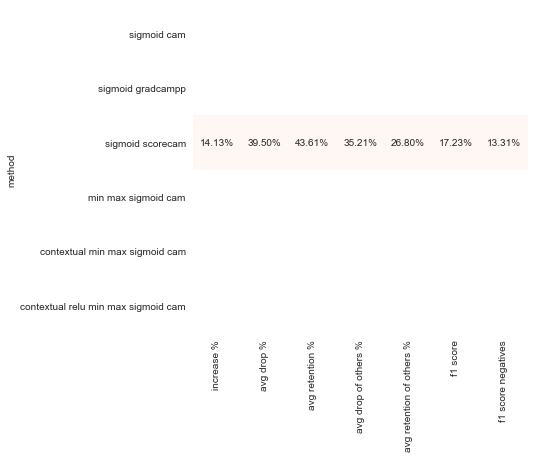

In [ ]:
#@title Macro Average (Class-Balanced)

macro_avg = (
  results
  .groupby('method')
  .mean()
  .reindex(methods)[list(metric_names)]
) / 100

macro_avg_hm = macro_avg.copy()
for m in minimizing_metrics:
  macro_avg_hm[m] = 1-macro_avg_hm[m]
macro_avg_hm -= macro_avg_hm.min(axis=0)
macro_avg_hm /= macro_avg_hm.max(axis=0) + 1e-07

plt.figure(figsize=(6, 6))
sns.heatmap(
  macro_avg_hm,
  fmt='.2%',
  annot=macro_avg,
  cmap='RdPu',
  cbar=False,
  xticklabels=[c.replace('_', ' ') for c in macro_avg.columns],
  yticklabels=[i.replace('_', ' ') for i in macro_avg.index],
);

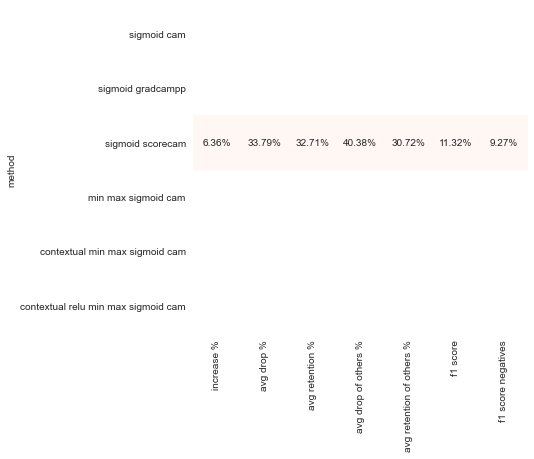

In [ ]:
#@title Weighted Average (Class Frequency Weighted)

total_detections = (
  results
  .groupby('method')
  .agg({'detections': 'sum'})
  .rename(columns={'detections': 'total_detections'})
)

w_avg = results.merge(total_detections, how='left', left_on='method', right_index=True)

metric_results = {
  m: w_avg[m] * w_avg.detections / w_avg.total_detections
  for m in metric_names
}
metric_results['method'] = w_avg.method
metric_results['label'] = w_avg.label

w_avg = (
  pd.DataFrame(metric_results)
  .groupby('method')
  .sum()
  .reindex(methods) / 100
)

hm = w_avg.copy()
for m in minimizing_metrics:
  hm[m] = 1-hm[m]
hm -= hm.min(axis=0)
hm /= hm.max(axis=0) + 1e-07

plt.figure(figsize=(6, 6))
sns.heatmap(
  hm,
  fmt='.2%',
  annot=w_avg,
  cmap='RdPu',
  cbar=False,
  xticklabels=[c.replace('_', ' ') for c in w_avg.columns],
  yticklabels=[i.replace('_', ' ') for i in w_avg.index]
);

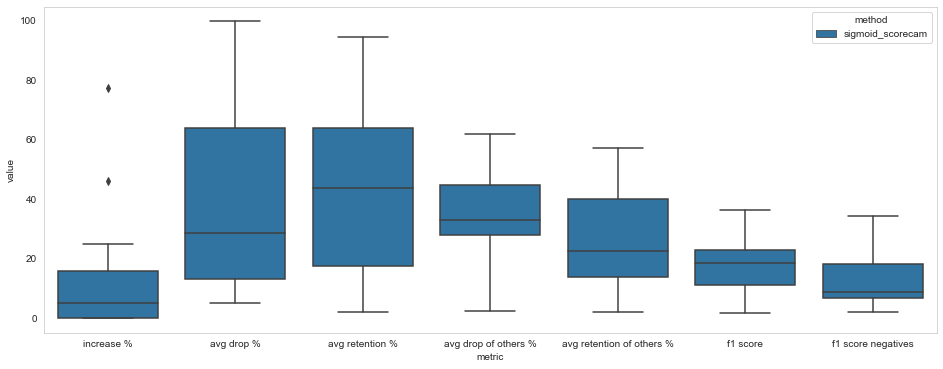

In [ ]:
#@title Detailed Results per Class

plt.figure(figsize=(16, 6))
sns.boxplot(
  data=results[results.method.isin(methods_detailed)]
       .melt(('method', 'label'), metric_names, 'metric'),
  hue='method',
  x='metric',
  y='value'
);

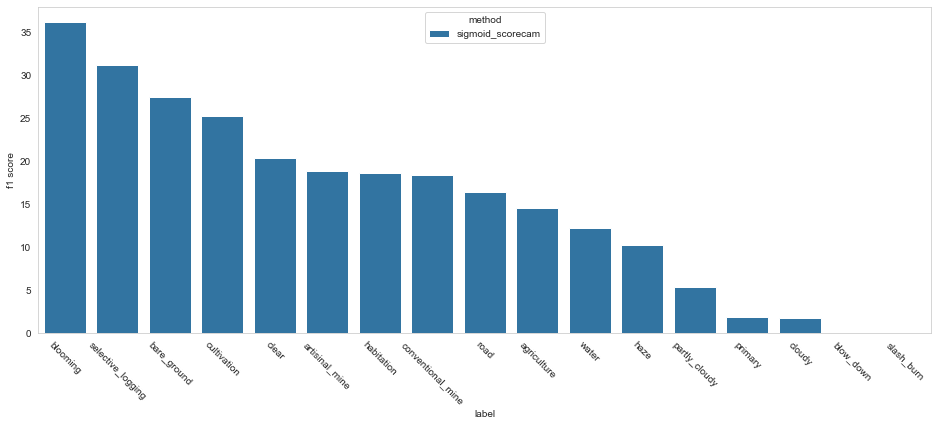

In [ ]:
#@title F1 Score by Label and CAM Method

plt.figure(figsize=(16, 6))
sns.barplot(
  data=results.sort_values('f1 score', ascending=False),
  hue='method',
  y='f1 score',
  x='label'
)
plt.xticks(rotation=-45);